# Cell 1: Install & Imports

In [1]:
# Install requirements if needed (uncomment if running in a fresh environment)
# !pip install torch numpy matplotlib scipy

from ArV_NeuroSynth import ArV_NeuroSynth
import bci_mat_loader 
import load_bci_mat_all_runs
import torch
import numpy as np
import matplotlib.pyplot as plt

# Cell 2: Data Loading

In [3]:
# Load EEG data from all runs in the .mat file
dataloader, eeg_tensor = load_bci_mat_all_runs.load_bci_mat_all_runs("A01T.mat", num_channels=4, segment_length=256, batch_size=32)
print("EEG tensor shape:", eeg_tensor.shape)

EEG tensor shape: (4, 671728)


# Cell 3: Model Initialization

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ArV_NeuroSynth(input_channels=4, seq_length=256, latent_dim=32, noise_dim=50).to(device)
print("Model initialized on device:", device)

Model initialized on device: cpu


# Cell 4: Training Loop for ArV_NeuroSynth

Epoch 1/20 - Loss: 104.868265
Epoch 2/20 - Loss: 100.696112
Epoch 3/20 - Loss: 104.332218
Epoch 4/20 - Loss: 99.455319
Epoch 5/20 - Loss: 99.046429
Epoch 6/20 - Loss: 98.655463
Epoch 7/20 - Loss: 99.232143
Epoch 8/20 - Loss: 97.794179
Epoch 9/20 - Loss: 97.635509
Epoch 10/20 - Loss: 95.426817
Epoch 11/20 - Loss: 100.615012
Epoch 12/20 - Loss: 98.232082
Epoch 13/20 - Loss: 97.389585
Epoch 14/20 - Loss: 93.734334
Epoch 15/20 - Loss: 94.034776
Epoch 16/20 - Loss: 92.684843
Epoch 17/20 - Loss: 94.741741
Epoch 18/20 - Loss: 90.182872
Epoch 19/20 - Loss: 90.987531
Epoch 20/20 - Loss: 90.029520
Model saved as arv_neurosynth_trained.pth


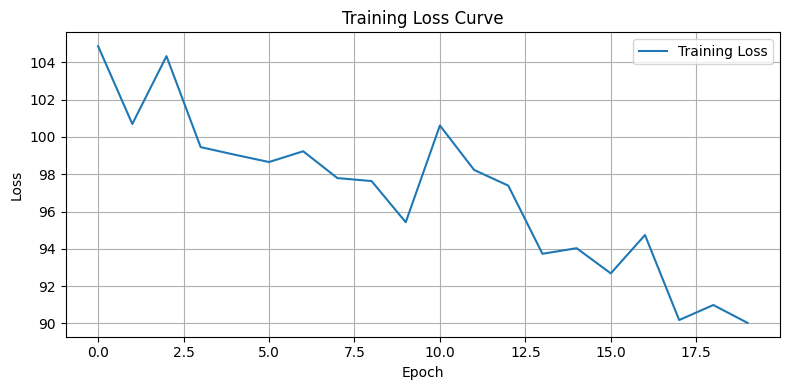

In [7]:
# Hyperparameters
epochs = 20
learning_rate = 1e-3

# Optimizer (Adam is common for VAE/GANs)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss function (MSE for reconstruction, you can add KL or adversarial losses as needed)
recon_loss_fn = torch.nn.MSELoss()

loss_history = []

def save_training_results(model, x_recon=None, plot=False, prefix="arv_neurosynth"):
    torch.save(model.state_dict(), f"{prefix}_trained.pth")
    print(f"Model saved as {prefix}_trained.pth")
    if x_recon is not None:
        np.save(f"{prefix}_reconstructed_eeg.npy", x_recon.cpu().numpy())
        print(f"Reconstructed EEG saved as {prefix}_reconstructed_eeg.npy")
    if plot and x_recon is not None:
        plt.figure(figsize=(12, 4))
        for ch in range(x_recon.shape[1]):
            plt.plot(x_recon.cpu()[0, ch], label=f"Ch{ch}")
        plt.legend()
        plt.title("Reconstructed EEG")
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{prefix}_reconstruction_plot.png")
        plt.close()
        print(f"Plot saved as {prefix}_reconstruction_plot.png")

def save_training_results(model, x_recon=None, plot=False, prefix="arv_neurosynth"):
    raise NotImplementedError

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for x_batch, in dataloader:
        x_batch = x_batch.to(device)
        # Forward pass (VAE mode)
        x_recon, mu, logvar, z = model(x_batch, mode='vae')
        # VAE loss: reconstruction + KL divergence
        recon_loss = recon_loss_fn(x_recon, x_batch)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + 0.01 * kl_loss  # 0.01 is a typical beta value for VAE, adjust as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x_batch.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")

# Save the final model and loss curve
save_training_results(model)

# Plot loss curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Cell 5: Save & Load Utilities

In [8]:
def save_training_results(model, x_recon=None, plot=False, prefix="arv_neurosynth"):
    torch.save(model.state_dict(), f"{prefix}_trained.pth")
    print(f"Model saved as {prefix}_trained.pth")
    if x_recon is not None:
        np.save(f"{prefix}_reconstructed_eeg.npy", x_recon.cpu().numpy())
        print(f"Reconstructed EEG saved as {prefix}_reconstructed_eeg.npy")
    if plot and x_recon is not None:
        plt.figure(figsize=(12, 4))
        for ch in range(x_recon.shape[1]):
            plt.plot(x_recon.cpu()[0, ch], label=f"Ch{ch}")
        plt.legend()
        plt.title("Reconstructed EEG")
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{prefix}_reconstruction_plot.png")
        plt.close()
        print(f"Plot saved as {prefix}_reconstruction_plot.png")

def load_trained_model(model_class, prefix="arv_neurosynth", **model_kwargs):
    model = model_class(**model_kwargs)
    model.load_state_dict(torch.load(f"{prefix}_trained.pth"))
    model.eval()
    print(f"Model loaded from {prefix}_trained.pth")
    return model

# Cell 6: Save Model and Results

In [9]:
# Ensure Cell 5 is executed before running this cell to define save_training_results
def save_training_results(model, x_recon=None, plot=False, prefix="arv_neurosynth"):
    torch.save(model.state_dict(), f"{prefix}_trained.pth")
    print(f"Model saved as {prefix}_trained.pth")
    if x_recon is not None:
        np.save(f"{prefix}_reconstructed_eeg.npy", x_recon.cpu().numpy())
        print(f"Reconstructed EEG saved as {prefix}_reconstructed_eeg.npy")
    if plot and x_recon is not None:
        plt.figure(figsize=(12, 4))
        for ch in range(x_recon.shape[1]):
            plt.plot(x_recon.cpu()[0, ch], label=f"Ch{ch}")
        plt.legend()
        plt.title("Reconstructed EEG")
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{prefix}_reconstruction_plot.png")
        plt.close()
        print(f"Plot saved as {prefix}_reconstruction_plot.png")

with torch.no_grad():
    x_real = next(iter(dataloader))[0][:1].to(device)
    x_recon, _, _, _ = model(x_real, mode='vae')
    save_training_results(model, x_recon, plot=True)  # Ensure function is defined in Cell 5

Model saved as arv_neurosynth_trained.pth
Reconstructed EEG saved as arv_neurosynth_reconstructed_eeg.npy
Plot saved as arv_neurosynth_reconstruction_plot.png


# Cell 7: Load Model Later

In [10]:
# Example: Load the trained model for inference or further training
model_loaded = load_trained_model(
    ArV_NeuroSynth,
    input_channels=4, seq_length=256, latent_dim=32, noise_dim=50
)

Model loaded from arv_neurosynth_trained.pth


# Cell 8: Visualize Results

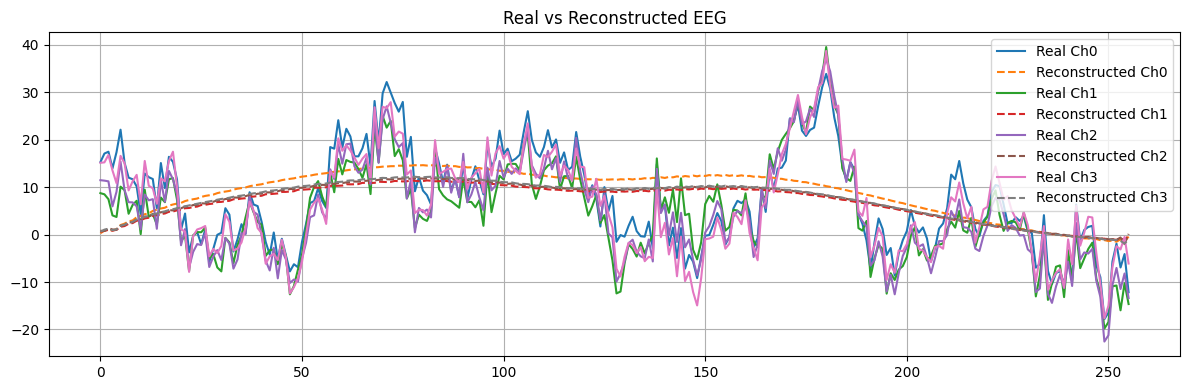

In [11]:
# Visualize real vs reconstructed EEG
plt.figure(figsize=(12, 4))
for ch in range(x_real.shape[1]):
    plt.plot(x_real.cpu()[0, ch], label=f"Real Ch{ch}")
    plt.plot(x_recon.cpu()[0, ch], '--', label=f"Reconstructed Ch{ch}")
plt.legend()
plt.title("Real vs Reconstructed EEG")
plt.grid()
plt.tight_layout()
plt.show()

# Cell 9: Compare Real and Reconstructed EEG

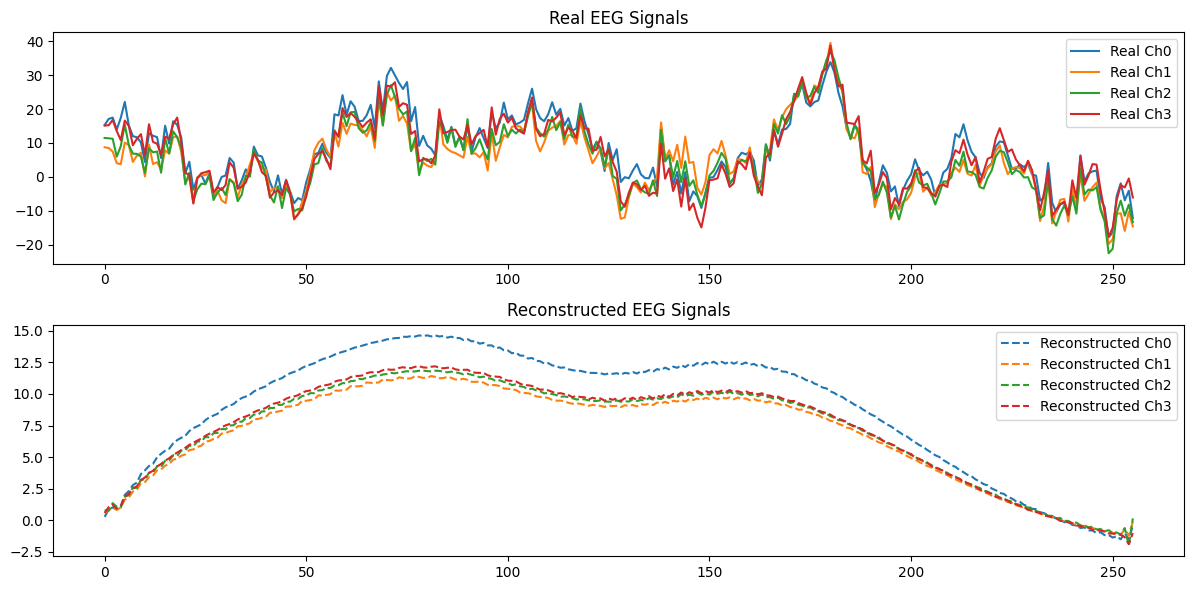

Comparison plot saved as real_vs_reconstructed_eeg_comparison.png


In [12]:
# Visualize and save real vs reconstructed EEG signals
plt.figure(figsize=(12, 6))
for ch in range(x_real.shape[1]):
    plt.subplot(2, 1, 1)
    plt.plot(x_real.cpu()[0, ch], label=f"Real Ch{ch}")
    plt.title("Real EEG Signals")
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x_recon.cpu()[0, ch], '--', label=f"Reconstructed Ch{ch}")
    plt.title("Reconstructed EEG Signals")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.savefig("real_vs_reconstructed_eeg_comparison.png")
plt.show()
print("Comparison plot saved as real_vs_reconstructed_eeg_comparison.png")

# Motivation

This notebook demonstrates ArV_NeuroSynth, a novel GAN-based model for simulating EEG signals, supporting the review article "Generative Adversarial Networks for Enhancing EEG Functional Connectivity Analysis in Neuroscience." The code showcases data augmentation, denoising, and the preservation of functional connectivity, addressing key challenges in EEG analysis.

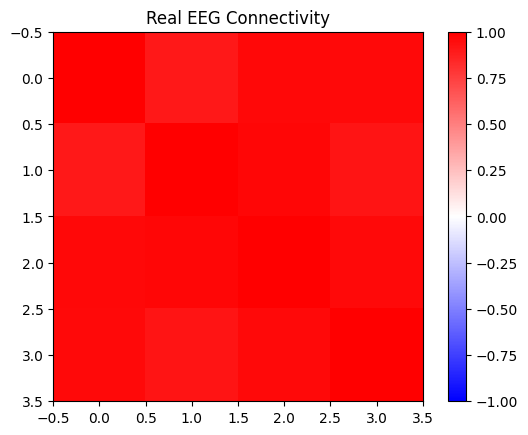

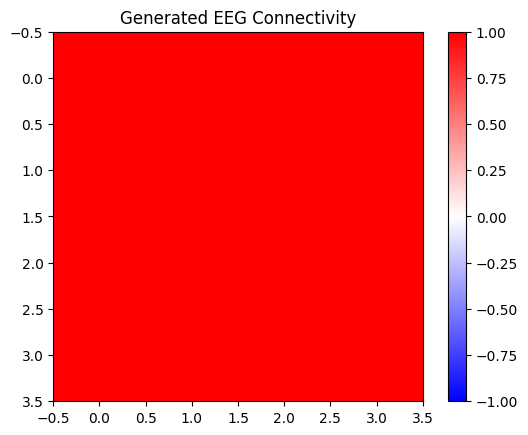

In [13]:
def plot_connectivity(eeg, title):
    # eeg: shape [batch, channels, time]
    conn = np.corrcoef(eeg[0].cpu().numpy())
    plt.imshow(conn, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_connectivity(x_real, "Real EEG Connectivity")
plot_connectivity(x_recon, "Generated EEG Connectivity")